## Solves Hansen model with continuos DP and efficient algorithm

#### Translated from Eva Carceles-Poveda's MATLAB codes

In [1]:
# Importing packages
import numpy as np

# This is used to calculate the excution time of several loops
import time

import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline 

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

#### The functions lgwt and acm are copied below.

In [2]:
def lgwt(N,a,b):
    """ Syntax: [x,w]=lgwt(N,a,b)
    
    This script is for computing definite integrals using Legendre-Gauss 
    Quadrature. Computes the Legendre-Gauss nodes and weights on an interval
    [a,b] with truncation order N.
    
    Suppose you have a continuous function f(x) which is defined on [a,b]
    which you can evaluate at any x in [a,b]. Simply evaluate it at all of
    the values contained in the x vector to obtain a vector f. Then compute
    the definite integral using sum(f.*w);
    
    Translated from Greg von Winckel's Matlab Script written on 02/25/2004
    """

    N = N-1
    N1 = N+1; N2 = N+2;

    xu = np.linspace(-1,1,N1)

    # Initial guess
    y=np.cos((2*np.arange(0,N+1)+1)*np.pi/(2*N+2))+(0.27/N1)*np.sin(np.pi*xu*N/N2)

    # Compute the zeros of the N+1 Legendre Polynomial
    # using the recursion relation and the Newton-Raphson method

    y0=2

    # Iterate until new points are uniformly within epsilon of old points
    while np.abs(y-y0).max() > np.finfo(float).eps:
        
        # Legendre-Gauss Vandermonde Matrix
        L=np.zeros((N1,N2))

        # Derivative of LGVM
        Lp=np.zeros((N1,N2))
        
        L[:,0]=1
        Lp[:,0]=0

        L[:,1]=y
        Lp[:,1]=1
        
         
        for k in np.arange(1,N1):
            L[:,k+1]=( (2*(k+1)-1)*y*L[:,k]-((k+1)-1)*L[:,k-1] )/(k+1)

            
        Lp=(N2)*(L[:,N1-1]-y*L[:,N2-1] )/(1-y**2)

        y0=y.copy()
        y=y0-L[:,N2-1]/Lp


    # Linear map from[-1,1] to [a,b]
    x = ((a*(1-y)+b*(1+y))/2).T

    # Compute the weights
    w = ((b-a)/((1-y**2)*Lp**2)*(N2/N1)**2).T
       
    return x, w

In [3]:
# scipy.stats.norm: a normal continuous random variable.
from scipy.stats import norm

# needed for Gauss-Lobatto only
from scipy.integrate import quad

# Adda-Cooper's method of approximating an AR(1) process with normally distributed innovation.
def acm(mu,rho,sigma,n,me=1):
    """ Syntax: [ss,tm,sd,sm,ssd,sac] = acm(mu,rho,sigma,n,me) 

    ss is state space, tm is transition matrix, sd is stationary distribution,
    sm is stationary mean, ssd is stationary standard deviation and sac is 
    stationary autocorrelation. mu is the mean of the AR process, rho is 
    the autocorrelation and sigma is the standard deviation of the innovation.
    n is the number of states and me stands for the method used in numerical integration.
    """
    
    tm = np.zeros((n,n))
    sg = sigma / (np.sqrt(1 - rho**2))     # sg is the variance of AR process
    
    # n + 1 interval nodes for defining the states, trucated at two ends.
    node = sg * norm.ppf(np.arange(0,n+1) / n + np.concatenate((np.array([np.spacing(1)]), np.zeros((1,7 - 1))[0],\
                                                                    (np.array([-np.spacing(1)]))))) + mu
    

    # lengths of n intervals.
    itv = node[1:n + 1] - node[0:n]
    

    ss = n * sg * (norm.pdf((node[0:n] - mu) / sg) - norm.pdf((node[1:n+1] - mu) / sg)) + mu
    
    # itvu is the upper bound of an interval, itvl likewise.
    f = lambda u,itvu,itvl: np.exp(-(u - mu)**2 / 2 / sg**2)*\
    (norm.cdf((itvu - mu*(1 - rho) - rho*u)/sigma) -\
     norm.cdf((itvl - mu*(1 - rho) - rho*u)/sigma)) / np.sqrt(2 * np.pi) / sg
    
    
    match me:
        case 1:
            # use Gauss-Legendre method

            # Generate 10 nodes and corresponding weights using Winckel's function lgwt.
            m = 10
            x,w = lgwt(m,-1,1)    

            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                tm[i,:] = 0.5 * itv * (np.matmul(w,f_i(np.matmul((x + 1)[:,np.newaxis], itv[np.newaxis,:]) / 2 \
                                                    + np.ones((m,1)) * node[0:n])))

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])
                

            stop = time.perf_counter()
            print("Time of the Gauss-Legendre method is:", round(stop - start,4))

        
        case 2:
            # use recursive adaptive Gauss-Lobatto quadrature
            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                for j in np.arange(0,n):
                    tm[i,j] = quad(f_i,node[j],node[j + 1])[0]

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])

            stop = time.perf_counter()
            print("Time of Gauss-Lobatto method is:", round(stop - start,4))

    sd = np.dot((np.concatenate((np.zeros((1,n - 1))[0],(np.array([1]))))),\
    np.linalg.inv((np.append(tm[:,0:n - 1] - np.eye(n,n - 1),np.ones((n,1)),1))))
    sd = sd / sum(sd)
    sm = np.dot(sd, ss)
    ssd = np.sqrt(np.dot((ss - sm)**2, sd.T))

    sac = (np.matmul((ss[:,np.newaxis] - sm),ss[np.newaxis,:] - sm) *\
           np.matmul(np.diag(sd),tm)).sum(axis=1).sum(axis=0) / ssd**2
        
        
    return ss,tm,sd,sm,ssd,sac

#### The Hodrick-Prescott filter function is copied below

In [4]:
def hp(T, lamb):
    matrix = np.zeros((T, T))

    matrix[0, 0:3] = [1 + lamb, -2 * lamb, lamb]
    matrix[1, 0:4] = [-2 * lamb, 1 + 5 * lamb, -4 * lamb, lamb]

    for i in np.arange(3,T-1):
        matrix[i-1, i-3 : i+2] = [lamb, -4*lamb, 1 + 6 * lamb, -4 * lamb, lamb]

    matrix[T-2, T-4:T] = [lamb, -4 * lamb, 1 + 5 * lamb, -2 * lamb]
    matrix[T-1, T-3:T] = [lamb, -2 * lamb, 1 + lamb]

    return matrix

### user defined functions for solving the problem:

In [5]:
def kronv(x,y):
    # Compute kroneck product of two column vector using basic
    # built-in functions for array manipulation instead of using
    # another built-in function kron, which involves non-basic
    # functions like meshgrid.
    
    # only accepts two-dimensional numpy arrays as inputs
    
    nx = x.size
    ny = y.size

    z = np.reshape(np.matmul(y,x.T),nx * ny,order="F")
    return z

def kronm(x,y):
    # Compute kroneck product of two matrices using kronv
    # only accepts two-dimensional numpy arrays as inputs
    
    nx,kx = x.shape
    ny,ky = y.shape
    
    z = np.zeros((nx * ny,kx * ky))
    for l in np.arange(0,kx):
        for m in np.arange(0,ky):
            z[:,l * ky + m] = kronv(x[:,l][:,np.newaxis],y[:,m][:,np.newaxis])
    
    return z

In [6]:
def linitp(x,x_grid,y_grid):
    # x_grid is a vector summarizing the information of the grid of x,
    # including the lower bound x_grid(1) and step size x_grid(2).
    # y_grid has the same number of columns as x, while the length of x
    # could be greater than y_grid. Users are required to make
    # sure x lies in the admissible region.

    k = x.shape[0]
    n,m = y_grid.shape

    Ix = np.fix((x - x_grid[0]) / x_grid[1])
    w = (x - x_grid[0]) / x_grid[1] - Ix

    arr_index1 = (np.maximum(Ix,0).astype(int),\
                 np.matmul(np.ones((k,1)), np.arange(0,m)[np.newaxis,:]).astype(int))
    #ind1 = np.ravel_multi_index(arr_index1, (n,m), order='F') # equivalent to sub2ind in Matlab
    
    arr_index2 = (np.minimum(Ix+1,n-1).astype(int),\
                  np.matmul(np.ones((k,1)), np.arange(0,m)[np.newaxis,:]).astype(int))

    #ind2 = np.ravel_multi_index(arr_index2, (n,m), order='F') # equivalent to sub2ind in Matlab
    
    #y_gridf = y_grid.flatten('F')
    #y = (1 - w) * y_gridf[ind1] + w * y_gridf[ind2]

    y = (1 - w) * y_grid[arr_index1] + w * y_grid[arr_index2]

    return y


In [7]:
# utility function
def fu(c, h, a):
    u = (1 - a) * np.log(c) + a * np.log(1 - h)
    return u


# production function
def fprod(k, alpha):
    y = k**alpha
    return y

# function to determine labor supply given k',k and theta
def fh(h,rik,alpha,a):
    # rik is the ratio of investment and capital (with shock)
    y = ((1 - a) * (1 - alpha) / a + 1) * h**(1 - alpha) -\
        (1 - a) * (1 - alpha) / a * h**(-alpha) - rik
    j = ((1 - a) * (1 - alpha) / a + 1) * (1 - alpha) * h**(-alpha) +\
        (1 - a) * (1 - alpha) * alpha / a * h**(-alpha - 1)
    return y, j


In [8]:
import scipy.optimize as opt

def fv(gc,gh,gk,tmt,ssk_grid,beta,a):
    # solve for value function using gc, gk and tmt
    
    u = fu(gc,gh,a)  # current utility
    
    # functional equation for v
    # scipy.optimize victorizes the input and output of the function, 
    # so we must reshape the input v to its original shape, and we must flatten the output of the function
    fneq = lambda v: (u + beta * np.matmul(linitp(gk,ssk_grid,v.reshape(gk.shape)),tmt) - v.reshape(gk.shape)).flatten()
    
    v0 = 1 * u / (1 - beta)

    v = opt.root(fneq,v0,method="lm").x.reshape(gk.shape)
    # or we can use the following:
    #v = opt.fsolve(fneq,v0).reshape(gk.shape)
    return v

In [9]:
def indlin(x,n):
    # Compute the linearized index of an index matrix x, presuming x is
    # generated from an array w which has one more dimension of length n.
    l,k = x.shape
    
    y = x.flatten('F') + kronv(np.ones((k,1)),n * np.arange(0,l)[:,np.newaxis]) + \
        kronv(n * l * np.arange(0,k)[:,np.newaxis],np.ones((l,1)))
    
    return y.astype(int)

In [10]:
#def maxv (x,sss,ssk,alpha,beta,ssk_grid,vful,i,j):
#    #print(x)
#    if (sss[j] * ssk[i]**alpha * x[1] + (1 - delta) * ssk[i] -x[0]) < 0:
#        print(x,sss[j],ssk[i],alpha,delta)
#    return -fu(sss[j] * ssk[i]**alpha * x[1] + (1 - delta) * ssk[i] -x[0],\
#                                         x[1]**(1 / (1 - alpha)),a)-\
#                    beta*linitp(np.array([[x[0]]]),ssk_grid,vful[:,j][:,np.newaxis])

In [11]:
# Use value function interpolation or policy function iteration to solve
# Hansen's RBC model with divisible labor supply.
# Translated from Yan Liu's Matlab code, 2011.4.9

# This is used for the root_scalar and minimize functions
from scipy.optimize import root_scalar,minimize

def rbcvipi(me,vime, PAR, DSS, SSK, SSS, TM):
    """ Syntax: [v,gk,gc,gi,gy,t] = bmvipi(me,vime,PAR DSS SSK SSS TM) 

    me = 1 corresponds to value function interpolation and me = 0
    corresponds to policy function iteration. vime indicates the method used
    in value function interpolation, with vime = 0 referring to discrete
    maximization and vime = 1 referring to continuous optimization
    """
    #--------------------------------------------------------------------------

    # vful_j is used to define maxv in value function iterpolation with continuous optimization
    alpha = PAR[0]
    beta = PAR[1]
    delta = PAR[2]
    gamma = PAR[3]
    a = PAR[4]
    bk = DSS[0]  # use the syntax b* to denote steady state value
    bc = DSS[1]
    bh = DSS[2]
    ssk = SSK  # nkx1
    nk = ssk.size
    sss = SSS     # ns x1
    ns = sss.size
    tmt = TM
    
    t = {'pi':0,'vi_dsc':0,'vi_ctn':0}
    ssk_grid = np.array([ssk[0],(ssk[-1] - ssk[0]) / (nk - 1)])
    # ssk_grid is used by all methods.
    
    #--------------------------------------------------------------------------
    
    
    if me == 0:
        # use policy iteration with linear iterpolation
        tm1 = kronm(tmt,np.append(1,np.zeros((1,ns)))[np.newaxis,:])
        tm1 = np.reshape(tm1[:,0:ns**2],(ns**2,ns),order="F")    # for computing E_t...
        
        gk_new = (1 - (1 - alpha) * delta) * np.matmul((ssk - bk)[:,np.newaxis], np.ones((1,ns)))\
        + bk * np.matmul(np.ones((nk,1)), (0.1 * (sss[np.newaxis,:] - 1) + 1))     
        gk_new = np.maximum(gk_new,ssk[0])
        gk_new = np.minimum(gk_new,ssk[-1])
        gh_new = -0.5 * alpha * delta * bk**(-alpha) /\
        ((1 - alpha) * ((1 - a) / a * (1 - alpha) + 1) * bh**(-alpha) + \
        alpha * (1 - alpha) * (1 - a) / a * bh**(-alpha - 1)) * \
        (ssk[:,np.newaxis] * np.ones((1,ns)) - bk) + bh * np.ones((nk,1)) * (0.1 * (sss[np.newaxis,:] - 1) + 1)
        # This choice is motivated by the approximation around steady state.
        
        
        gk_old = np.zeros((nk,ns))
        gh_old = np.zeros((nk,ns))
        tol = max(np.linalg.norm(gk_old - gk_new,1),np.linalg.norm(gh_old - gh_new,1))
        nitr = 0
        
        start = time.perf_counter()
        while tol > 1e-6 and nitr <= 2500:
            gk_old = gk_new.copy()
            gh_old = gh_new.copy()
            
            # Note: using numpy.kron is much faster than using the basic kronm function that is defined here
            
            k1 = kronm(gk_old, np.ones((1,ns)))  # array of k_t+1
            k2 = linitp(k1,ssk_grid,kronm(np.ones((1,ns)),gk_old))  # array of k_t+2
            
            h1 = kronm(np.ones((1,ns)),linitp(gk_old,ssk_grid,gh_old))
            
            c1 = kronm(fprod(gk_old,alpha),sss[np.newaxis,:])*(h1**(1 - alpha)) + (1 - delta) * k1 - k2 # array of c_t+1
            c1 = np.maximum(c1,1e-3) # prohibit zero consumption
            c1 = np.minimum(c1,5)

            # array of marginal productivity
            mp = 1 - delta + alpha * kronm(gk_old**(alpha - 1),sss[np.newaxis,:])*(h1**(1 - alpha)) 
            
            gc = (beta * np.matmul(c1**(-gamma) * mp, tm1))**(-1 / gamma)
            
            for i in np.arange(0,nk):
                for j in np.arange(0,ns):
                    gh_new[i,j] = root_scalar(lambda h: (h**alpha / (1 - h) - \
                        (1 - a) * (1 - alpha) / a / gc[i,j] * sss[j] * ssk[i]**alpha),\
                                              bracket=[1e-4,1 - 1e-4]).root
                    
            gh_new = np.minimum(gh_new,0.5)
            gh_new = np.maximum(gh_new,0.1)
            
            gk_new = np.matmul(fprod(ssk[:,np.newaxis],alpha), sss[np.newaxis,:]) * (gh_new**(1 - alpha)) \
            + (1 - delta) * np.matmul(ssk[:,np.newaxis], np.ones((1,ns))) - gc
            gk_new = np.maximum(gk_new,ssk[0])
            gk_new = np.minimum(gk_new,ssk[-1])
            
            tol = max(np.linalg.norm(gk_old - gk_new,1),np.linalg.norm(gh_old - gh_new,1))
            nitr = nitr + 1

        stop = time.perf_counter()
        t['pi'] = stop - start
        print("Elapsed time for the while loop (policy iteration) is:", round(t['pi'],4), "seconds")   
        print('Number of iterations of the while loop:', nitr)
        
        gk = gk_new.copy()
        gh = gh_new.copy()
        gi = gk - (1 - delta) * np.matmul(ssk[:,np.newaxis], np.ones((1,ns)))
        gy = gi + gc
        v = fv(gc,gh,gk,tmt,ssk_grid,beta,a)
        
     
    elif me == 1 and vime == 0:
        # Use value function iteration with linear iterpolation
        # Use discrete maximization
        
        vnew = 1 * fu(bc,bh,a) * np.ones((nk,ns)) / (1 - beta) 
        vold = np.zeros((nk,ns))
        nkd = 50 * nk
        # A denser space for k'.
        sskd = np.linspace(ssk[0],ssk[-1],nkd) # nkd x 1
        
        iv = kronv(np.ones((nk,1)), sskd[:,np.newaxis]) - kronv((1 - delta) * ssk[:,np.newaxis], np.ones((nkd,1)))
        iv = kronv(np.ones((ns,1)),iv[:,np.newaxis])
        
        
        # for each combination of k',k and theta, solve for h
        h = np.zeros((nkd * nk * ns,1))   # heuristic state space of h
        prodk = kronv(sss[:,np.newaxis],kronv(fprod(ssk[:,np.newaxis],alpha),np.ones((nkd,1)))[:,np.newaxis])
        rik = iv / prodk
        
        start = time.perf_counter()
        for i in np.arange(0,nkd * nk * ns):
            fh_i = lambda x: fh(x,rik[i],alpha,a)[0]
            h[i] = root_scalar(fh_i, bracket=[0.001,2]).root

        th = time.perf_counter() - start
        print("Time for computing h is:", round(th,4),"seconds")
        h = np.minimum(h,1 - 1e-6)
        h = np.maximum(h,0)   # truncate h at 0 and 1
        
        c = prodk*np.squeeze(h)**(1 - alpha)-iv
        Ic = np.argwhere(c > 0)
        
        u = -0.5 * np.finfo(float).max * np.ones((nkd * nk * ns,1))
        u[Ic] = fu(c[:,np.newaxis][Ic],h[Ic],a)
        
        u = u.reshape((nkd,nk,ns),order="F")
        
        
        tol = np.linalg.norm(vnew - vold,1)
        nitr = 0
        
        start = time.perf_counter()
        while tol > 1e-6 and nitr <= 2500:            
            vold = vnew.copy()
            vful = np.matmul(vold, tmt)
            vfuld = linitp(np.matmul(sskd[:,np.newaxis], np.ones((1,ns))),ssk_grid,vful)

            # Using the built-in numpy.kron is much faster than using the basic kronm and kronv 
            #vfuld = np.reshape(kronm(np.ones((nk,1)),vfuld),(nkd,nk,ns), order='F')
            vfuld = np.reshape(np.kron(np.ones((nk,1)), vfuld), (nkd,nk,ns), order='F') 

            #vnew = (u + beta * vfuld).max(axis=0,keepdims=True)
            #vnew = np.reshape(vnew,(nk,ns))
            #vnew = (u + beta * vfuld).max(axis=0)
            vnew = np.amax(u + beta * vfuld, axis=0)
            
            tol = np.linalg.norm(vnew - vold,1)
            nitr = nitr + 1

        stop = time.perf_counter()
        t['vi_dsc'] = stop - start
        print("Elapsed time for the while loop (discrete value function iteration) is:", round(t['vi_dsc'],4),"seconds")   
        print('Number of iterations of the while loop:', nitr)
        
        vful = np.matmul(vnew, tmt)
        vfuld = linitp(np.matmul(sskd[:,np.newaxis], np.ones((1,ns))),ssk_grid,vful)
        vfuld = np.reshape(kronm(np.ones((nk,1)), vfuld), (nkd,nk,ns), order='F')

        v, Igk = (u + beta * vfuld).max(axis=0), (u + beta * vfuld).argmax(axis=0) # Igk contains indices of gk
        gk = sskd[Igk]
        
        Iopt = np.reshape(indlin(Igk,nkd),(nk,ns),order='F')

        # compute the linearized index for the optimal choice array of the
        # form k.T by k by theta
        gi = iv[Iopt]
        gh = h.squeeze()[Iopt]
        gc = c[Iopt]
        gy = gc + gi
        
        
    else:
        # Use fmincon to optimize
        
        gk = (1 - (1 - alpha) * delta) * np.matmul((ssk - bk)[:,np.newaxis], np.ones((1,ns)))\
        + bk * np.matmul(np.ones((nk,1)), (0.1 * (sss[np.newaxis,:] - 1) + 1))
        # gk = np.maximum(gk,ssk[0])
        # gk = np.minimum(gk,ssk[-1])
        
        gh = -0.5 * alpha * delta * bk**(-alpha) /\
        ((1 - alpha) * ((1 - a) / a * (1 - alpha) + 1) * bh**(-alpha) + \
        alpha * (1 - alpha) * (1 - a) / a * bh**(-alpha - 1)) * \
        (ssk[:,np.newaxis] * np.ones((1,ns)) - bk) + bh * np.ones((nk,1)) * (0.1 * (sss[np.newaxis,:] - 1) + 1)
                
        gc = np.matmul(fprod(ssk[:,np.newaxis],alpha), sss[np.newaxis,:]) * (gh**(1 - alpha))+\
        (1 - delta) * np.matmul(ssk[:,np.newaxis], np.ones((1,ns))) - gk
        gc = np.maximum(gc,0.1)
        
        vnew = fv(gc,gh,gk,tmt,ssk_grid,beta,a)
        vold = np.zeros((nk,ns))

        ub = np.array([ssk[-1],0.8])
        lb = np.array([ssk[0] - 5,0.1])
        bnds = ((lb[0],ub[0]),(lb[1],ub[1]))
                
        tol = np.linalg.norm(vnew - vold,1)
        nitr = 0
        start = time.perf_counter()
        while tol > 1e-4 and nitr <= 1500:
            vold = vnew.copy()
            vful = np.matmul(vold, tmt)
            
            nitr = nitr + 1
            startfor = time.perf_counter()
            for i in np.arange(0,nk):
                for j in np.arange(0,ns):

                    maxv = lambda x: -fu(sss[j] * ssk[i]**alpha * x[1] + (1 - delta) * ssk[i] -x[0],\
                                         x[1]**(1 / (1 - alpha)),a)-\
                    beta*linitp(np.array([[x[0]]]),ssk_grid,vful[:,j][:,np.newaxis])
                    
                    A = np.array([[1,-sss[j] * ssk[i]**alpha]])
                    b = np.array([(1 - delta) * ssk[i] - 0.1])
                    cons = [{"type": "ineq", "fun": lambda x: A @ x - b}]
                    
                    result = minimize(maxv,x0=(gk[i,j],gh[i,j]**(1 - alpha)),method='trust-constr',\
                                         bounds=bnds,constraints=cons)
                    
                    # Note: there is a problem with the minimize method. Some of the values that the minimize method chooses
                    # create a concumption value that is negative, which created an error when the log is taken inside
                    # the fu (utility) function

                    #,args=(sss,ssk,alpha,beta,ssk_grid,vful,i,j,)
                                        
                    g = result.x
                    vnew[i,j] = result.fun
                    gk[i,j] = g[0]
                    gh[i,j] = g[1]**(1 / (1 - alpha))
            

            stopfor = time.perf_counter()
            print("Elapsed time for the for loops for iteration",'\033[1m' + str(nitr) + '\033[0m',\
                  "is",round(stopfor-startfor,4),"seconds")
            vnew = -vnew
            tol = np.linalg.norm(vnew - vold,1)
            

        stop = time.perf_counter()
        t['vi_ctn'] = stop - start
        print("Elapsed time for the while loop (continuous value function iteration) is:", round(t['vi_ctn'],4),"seconds")   
        print('Number of iterations of the while loop:', nitr)
            
        v = vnew.copy()
        gi = gk - (1 - delta) * np.dot(ssk[:,np.newaxis], np.ones((1,ns)))
        gy = np.dot(fprod(ssk[:,np.newaxis],alpha), sss[np.newaxis,:])
        gc = gy - gi
        
    
    return v,gk,gh,gc,gi,gy,t

In [12]:
# Simulate discrete finite state Markov chain
# Yan Liu, 2011.4.7

def mcsim(ss,tm,T):
    # ss is state space, tm is transition matrix, and
    # T is the number of periods to be simulated

    n = ss.size
    sd = np.matmul((np.concatenate((np.zeros((1,n - 1))[0],(np.array([1]))))),\
    np.linalg.inv((np.append(tm[0:n - 1,:].T - np.eye(n,n - 1),np.ones((n,1)),1)))) # stationary distribution
    
    sd = sd.T / np.sum(sd)
    
    Ix = np.zeros((T,1),dtype=int)    # indices of the chain
    y = np.random.random((T,1))      # random vector

    Ix[0] = np.argwhere(sd.cumsum() >= y[0])[0]

    tmcum = np.cumsum(tm,1).T    # use the transpose to accelerate computations
    for t in np.arange(1,T):
        Ix[t] = np.argwhere(tmcum[:,Ix[t - 1]] >= y[t])[0,0]

    return Ix

In [13]:
alpha = 0.36
beta = 0.99
gamma = 1       # log utility
delta = 0.025
a = 2/3        
PAR = np.array([alpha,beta,delta,gamma,a])  # a governs labor supply

In [14]:
# Discretize shock
SSS, TM = acm(0,0.95,0.00712,7,1)[0:2]
SSS = np.exp(SSS)

Time of the Gauss-Legendre method is: 0.0019


In [15]:
# Steady state
br = (1 / alpha / beta + (delta - 1) / alpha)**(1 / (1 - alpha))
bk = (1 - a) * (1 - alpha) / ((1 - alpha + a * alpha) * br - a * delta * br**alpha)
bh = br * bk
# del br
bi = delta * bk
bc = bk**alpha * bh**(1 - alpha) - bi
DSS = np.array([bk,bc,bh,bi])

In [16]:
# Discretize capital
krange = np.array([0.85,1.15])
nk = 50
SSK = np.linspace(krange[0] * bk, krange[1] * bk, nk)

In [17]:
print('Choose the method for solving the model:\n')
print('-- 1 policy iteration with interpolation\n')
print('-- 2 discrete value function iteration with interpolation\n')
print('-- 3 continuous value function iteration with interpolation\n')


while True:
    try:
        me = int(input('-- '))
    except ValueError:
        print("Please enter a valid integer [1-2-3]")
        continue
    else:
        if me not in [1,2,3]:
            print("Please enter a valid integer [1-2-3]")
            continue
        else:
            print(f'You entered: {me}')
            break


Choose the method for solving the model:

-- 1 policy iteration with interpolation

-- 2 discrete value function iteration with interpolation

-- 3 continuous value function iteration with interpolation

-- 1
You entered: 1


In [18]:
while True:
    findergk = input('Find the ergodic set first (y/n): ') # Request Unprocessed Text Input, y = yes, n = no

    if findergk not in ['y','n']:
        print('Please enter a valid response [y/n]\n')
        continue
    else:
        print(f'You entered {findergk}')
        break


Find the ergodic set first (y/n): y
You entered y


In [19]:
#--------------------------------------------------------------------------
# First, find the ergodic set for chosen method
#--------------------------------------------------------------------------

if findergk == 'y':
    match me:
        case 1:
            v,gk,gh,gc,gi,gy,t = rbcvipi(0,0,PAR, DSS, SSK, SSS, TM)
            
            ergk_pi = SSK[[np.where(gk[:,0] > SSK)[0][-1]+1,np.where(gk[:,-1] < SSK)[0][0]-1]]/bk
            print('ergodic set of capital:', ergk_pi)
            with open('ergk.npy', 'wb') as f:
                np.save(f, ergk_pi)
            
        case 2:
            v,gk,gh,gc,gi,gy,t = rbcvipi(1,0,PAR, DSS, SSK, SSS, TM)
            
            ergk_vi_dsc = SSK[[np.where(np.around(gk[:,0],4) > np.around(SSK,4))[0][-1]+1,\
                               np.where(np.around(gk[:,-1],4) < np.around(SSK,4))[0][0]-1]]/bk
            print('ergodic set of capital:', ergk_vi_dsc)
            with open('ergk.npy', 'wb') as f:
                np.save(f, ergk_vi_dsc)            
            
        case 3:
            v,gk,gh,gc,gi,gy,t = rbcvipi(1,1,PAR, DSS, SSK, SSS, TM)
            
            ergk_vi_ctn = SSK[[np.where(gk[:,0] > SSK)[0][-1]+1,np.where(gk[:,-1] < SSK)[0][0]-1]]/bk
            print('ergodic set of capital:', ergk_vi_ctn)
            with open('ergk.npy', 'wb') as f:
                np.save(f, ergk_vi_ctn)
            


            

Elapsed time for the while loop (policy iteration) is: 1.133 seconds
Number of iterations of the while loop: 119
ergodic set of capital: [0.9051 1.0888]


In [20]:
while True:
    solvemodel = input('Solve the model using existing ergk (y/n): ') # Request Unprocessed Text Input, y = yes, n = no

    if solvemodel not in ['y','n']:
        print('Please enter a valid response [y/n]\n')
        continue
    else:
        print(f'You entered {solvemodel}')
        break


Solve the model using existing ergk (y/n): y
You entered y


In [21]:
import shelve

#--------------------------------------------------------------------------
# Solve the model over ergodic set
#--------------------------------------------------------------------------
if solvemodel == 'y':
    nk=50
    match me:
        case 1:
            ergk_pi = np.load('./ergk.npy')

            krange = ergk_pi
            SSK = np.linspace(krange[0] * bk, krange[1] * bk, nk) 

            v,gk,gh,gc,gi,gy,t = rbcvipi(0,0,PAR, DSS, SSK, SSS, TM)
            
            save_shelf = shelve.open('./bm_pi_ergk.pkl','n')
            for k in dir():
                try:
                    save_shelf[k] = globals()[k]
                except Exception:
                    pass
            save_shelf.close()
            
        case 2:
            ergk_vi_dsc = np.load('./ergk.npy')
            
            krange = ergk_vi_dsc
            SSK = np.linspace(krange[0] * bk, krange[1] * bk, nk) 
            
            v,gk,gh,gc,gi,gy,t = rbcvipi(1,0,PAR, DSS, SSK, SSS, TM)
            
            save_shelf = shelve.open('./bm_vi_dsc_ergk.pkl','n')
            for k in dir():
                try:
                    save_shelf[k] = globals()[k]
                except Exception:
                    pass
            save_shelf.close()
            
        case 3:    
            ergk_vi_ctn = np.load('./ergk.npy')
            
            krange = ergk_vi_ctn
            SSK = np.linspace(krange[0] * bk, krange[1] * bk, nk) 
            
            v,gk,gh,gc,gi,gy,t = rbcvipi(1,1,PAR, DSS, SSK, SSS, TM)
            
            save_shelf = shelve.open('./bm_vi_ctn_ergk.pkl','n')
            for k in dir():
                try:
                    save_shelf[k] = globals()[k]
                except Exception:
                    pass
            save_shelf.close()


            

Elapsed time for the while loop (policy iteration) is: 1.1692 seconds
Number of iterations of the while loop: 126


In [22]:
#for restoring variables

#import shelve

#bk_restore = shelve.open('./your_bk_shelve.pkl')
#for k in bk_restore:
#    globals()[k] = bk_restore[k]
#bk_restore.close()

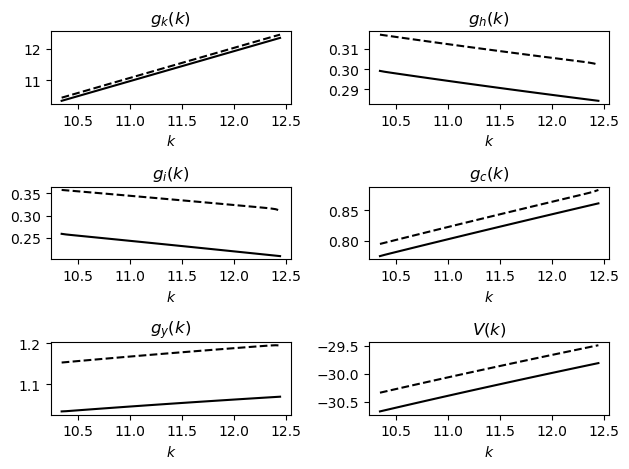

In [23]:
if solvemodel == 'y':

    fig1, axs1 = plt.subplots(3, 2)

    axs1[0,0].plot(SSK, gk[:,0], 'k-')
    axs1[0,0].plot(SSK, gk[:,-1], 'k--')
    axs1[0,0].set(xlabel='$k$', title='$g_{k}(k)$')

    axs1[0,1].plot(SSK, gh[:,0], 'k-')
    axs1[0,1].plot(SSK, gh[:,-1], 'k--')
    axs1[0,1].set(xlabel='$k$', title='$g_{h}(k)$')

    axs1[1,0].plot(SSK, gi[:,0], 'k-')
    axs1[1,0].plot(SSK, gi[:,-1], 'k--')
    axs1[1,0].set(xlabel='$k$', title='$g_{i}(k)$')

    axs1[1,1].plot(SSK, gc[:,0], 'k-')
    axs1[1,1].plot(SSK, gc[:,-1], 'k--')
    axs1[1,1].set(xlabel='$k$', title='$g_{c}(k)$')

    axs1[2,0].plot(SSK, gy[:,0], 'k-')
    axs1[2,0].plot(SSK, gy[:,-1], 'k--')
    axs1[2,0].set(xlabel='$k$', title='$g_{y}(k)$')

    axs1[2,1].plot(SSK, v[:,0], 'k-')
    axs1[2,1].plot(SSK, v[:,-1], 'k--')
    axs1[2,1].set(xlabel='$k$', title='$V(k)$')

    plt.tight_layout()
    plt.savefig('Hansen_CDP_eff_policy_value.jpg', dpi=800)
    plt.show()
    plt.close(fig1)

In [24]:
#--------------------------------------------------------------------------
# Simulation for Hansen model
#--------------------------------------------------------------------------
if solvemodel == 'y':

    #np.random.seed(1337)

    ss = SSS
    tm = TM
    ns = ss.size
    ssk = SSK
    nk = ssk.size

    T = 115
    N = 100

    w = 1600   # Weight of HP filter
    fm = hp(T,w)   # get the filtering matrix fm

    stat = np.zeros((N,12))     # store statistics for each simulation
    hpd = np.zeros((T,6))

    k = np.ones((T,1))
    ind = np.floor(nk / 2).astype(int)-1
    kstep = (ssk[-1] - ssk[0]) / (nk - 1)
    ssk_grid = np.array([ssk[0],(ssk[-1] - ssk[0]) / (nk - 1)])

    for n in np.arange(0,N):
        Is = mcsim(ss,tm,T)

        k[0] = ssk[ind]
        for t in np.arange(1,T):
            j = 1
            k[t] = linitp(k[t-1],ssk_grid,gk[:,Is[t-1]])

        logsimk = np.log(k)
        logsimi = np.log(linitp(k.T,ssk_grid,gi[:,Is.squeeze()]).T)
        logsimc = np.log(linitp(k.T,ssk_grid,gc[:,Is.squeeze()]).T)
        logsimh = np.log(linitp(k.T,ssk_grid,gh[:,Is.squeeze()]).T)
        logsimy = np.log(linitp(k.T,ssk_grid,gy[:,Is.squeeze()]).T)
        logsimp = logsimy - logsimh  # productivity

        hpd[:,[0]] = logsimy - np.linalg.solve(fm,logsimy)
        hpd[:,[1]] = logsimc - np.linalg.solve(fm,logsimc)
        hpd[:,[2]] = logsimi - np.linalg.solve(fm,logsimi)
        hpd[:,[3]] = logsimk - np.linalg.solve(fm,logsimk)
        hpd[:,[4]] = logsimh - np.linalg.solve(fm,logsimh)
        hpd[:,[5]] = logsimp - np.linalg.solve(fm,logsimp)

        stat[n,0:6] = np.std(hpd,axis=0)
        stat[n,6:12] = np.corrcoef(hpd[:,0],hpd,rowvar=False)[0,1:]

    A=np.mean(stat,axis=0)
    print('HANSEN: std(x)/std(y) corr(x,y) for y, c, i, k, h, prod')
    print(np.concatenate((np.array([[1.36, 0.42, 4.24, 0.36, 0.7, 0.68]]).T/1.36, \
                      np.array([[1, 0.89, 0.99, 0.06, 0.98, 0.98]]).T),axis=1))
    print('std(x) std(x)/std(y) corr(x,y) for y, i, c, k, h, prod:')
    print(np.concatenate(((A[0:6]*100)[:,np.newaxis], ((A[0:6]*100)/(A[0]*100))[:,np.newaxis], A[6:12][:,np.newaxis]),axis=1))

HANSEN: std(x)/std(y) corr(x,y) for y, c, i, k, h, prod
[[1.     1.    ]
 [0.3088 0.89  ]
 [3.1176 0.99  ]
 [0.2647 0.06  ]
 [0.5147 0.98  ]
 [0.5    0.98  ]]
std(x) std(x)/std(y) corr(x,y) for y, i, c, k, h, prod:
[[1.6605 1.     1.    ]
 [0.459  0.2764 0.8241]
 [5.5045 3.3149 0.9875]
 [0.4532 0.2729 0.0476]
 [0.9151 0.5511 0.9801]
 [0.7852 0.4729 0.9728]]


In [25]:
#!jupyter nbconvert --to script Hansen_CDP_eff.ipynb